<a href="https://colab.research.google.com/github/rmanicav/21Days-21Projects-MachineLearning/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Project 3: House Price Prediction (Regression)
Project Objective: To build a regression model that accurately predicts the sale price of houses based
on a large number of features. This project will cover the complete machine learning workflow,
from deep EDA to advanced preprocessing, feature engineering, model training, and evaluation.
'''


In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import os

# Set plot style
sns.set_style('darkgrid')

In [ ]:
# Install the Kaggle library
!pip install -q kaggle

# Use Colab's file uploader
from google.colab import files
print("Please upload the kaggle.json file you downloaded from your Kaggle account.")
files.upload()

# Create a directory for the Kaggle API configuration
!mkdir -p ~/.kaggle
# Move the uploaded kaggle.json to the required directory
!cp kaggle.json ~/.kaggle/
# Set the correct permissions for the file

Please upload the kaggle.json file you downloaded from your Kaggle account.


Saving kaggle.json to kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Download the dataset from the 'house-prices-advanced-regression-techniques' competition
!kaggle competitions download -c house-prices-advanced-regression-techniques

# Unzip the downloaded files
!unzip -o house-prices-advanced-regression-techniques.zip

print("\nDataset downloaded and unzipped.")

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 476MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               

Dataset downloaded and unzipped.


In [ ]:
# Now, load the data from the unzipped CSV files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Set the 'Id' column as the index for consistency
train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

print("Data loaded successfully:")
train_df.tail(1)

Training data shape: (1460, 80)
Testing data shape: (1459, 79)
Data loaded successfully:


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [ ]:
train_df.shape

(1460, 80)

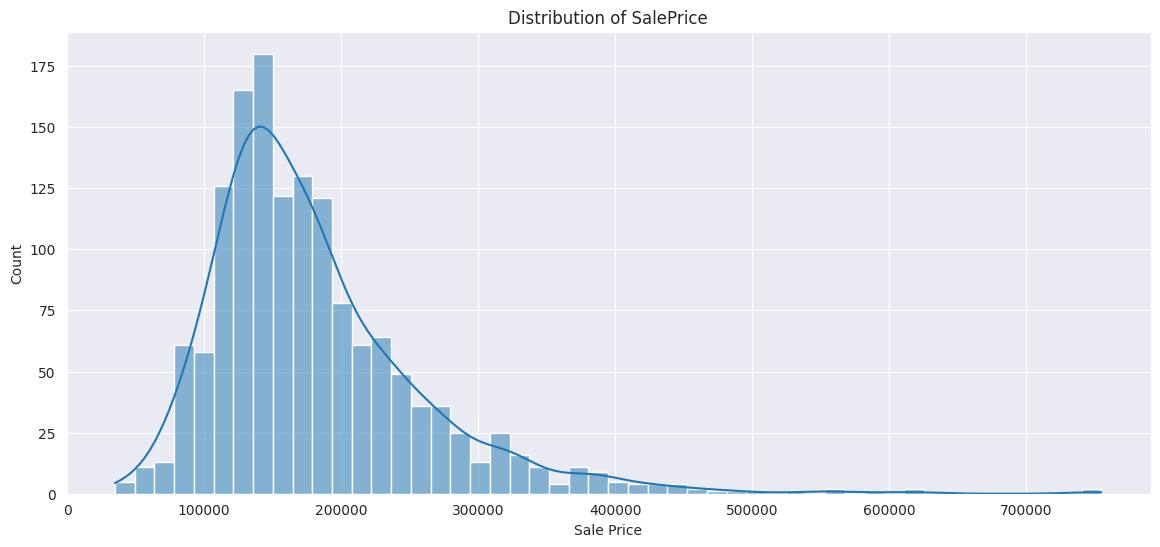

Skewness of SalePrice: 1.8828757597682129


In [ ]:
plt.figure(figsize=(14, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('Sale Price')
plt.show()

print(f"Skewness of SalePrice: {train_df['SalePrice'].skew()}")

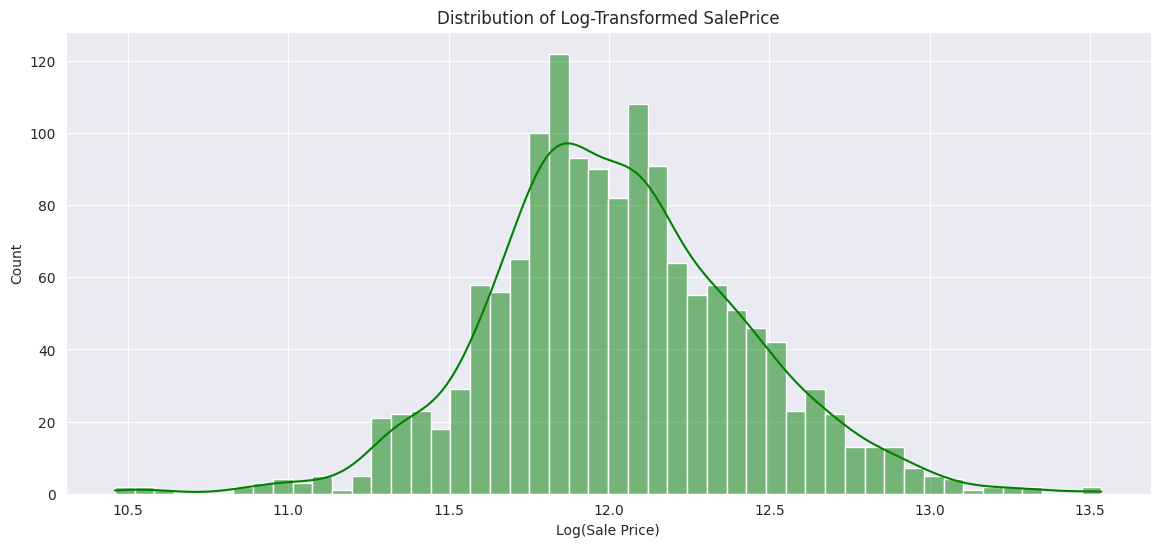

Skewness of Log-Transformed SalePrice: 0.12134661989685333


In [ ]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

plt.figure(figsize=(14, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50, color='green')
plt.title('Distribution of Log-Transformed SalePrice')
plt.xlabel('Log(Sale Price)')
plt.show()

print(f"Skewness of Log-Transformed SalePrice: {train_df['SalePrice'].skew()}")

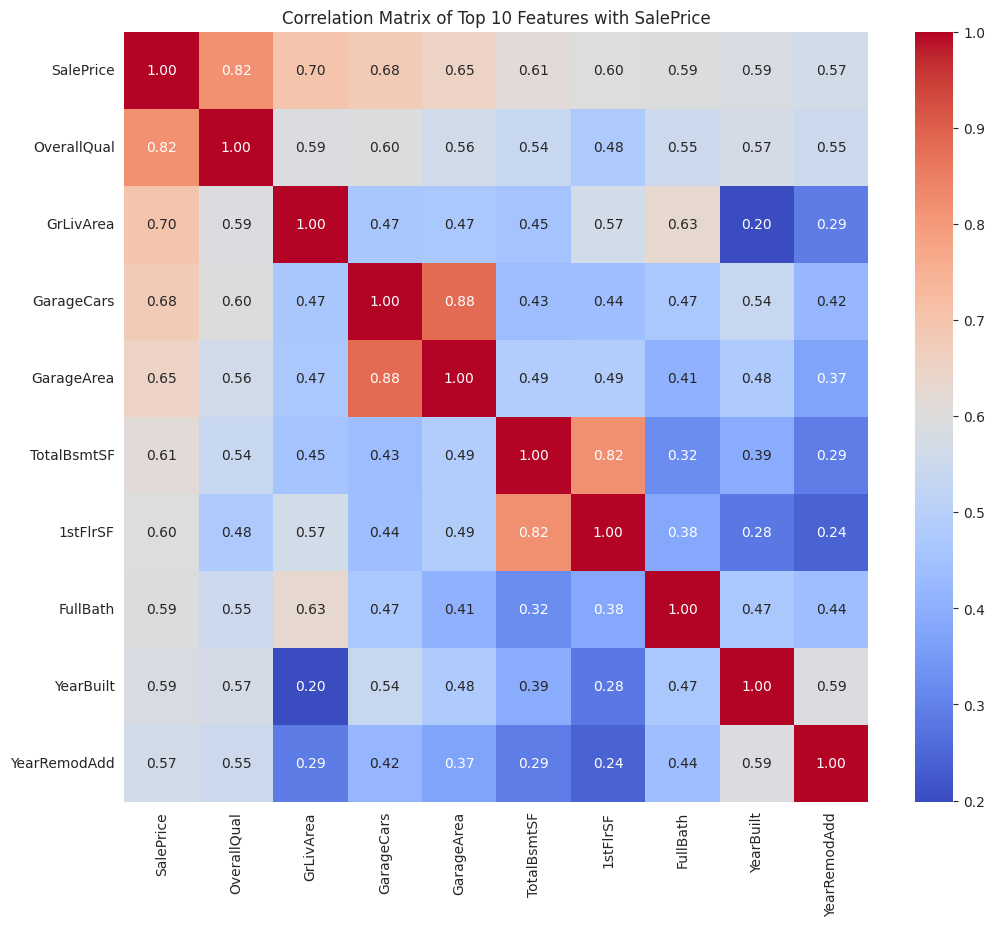

In [ ]:
# Find the top 10 features most correlated with SalePrice
corrmat = train_df.corr(numeric_only=True)
top_corr_features = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
top_corr_matrix = train_df[top_corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

In [ ]:
# Combine train and test data for consistent preprocessing
all_data = pd.concat((train_df.loc[:,:'SaleCondition'],
                      test_df.loc[:,:'SaleCondition']))

print(f"Combined data shape: {all_data.shape}")

Combined data shape: (2919, 79)


In [ ]:
# Find missing values in the current all_data
missing_data = all_data.isna().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]

print("Features with missing values:")
print(missing_data)

Features with missing values:
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Electrical         1
Exterior2nd        1
BsmtFinSF2         1
dtype: int64


In [ ]:
# Impute numerical features with 0
numerical_cols_to_impute_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
for col in numerical_cols_to_impute_zero:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

In [ ]:
all_data['LotFrontage'].value_counts()

,count
LotFrontage,
60.0,276
80.0,137
70.0,133
50.0,117
75.0,105
...,...
155.0,1
126.0,1
200.0,1


In [ ]:
if 'LotFrontage' in all_data.columns and all_data['LotFrontage'].isna().any():
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# Impute categorical features with 'None' (for features where NA means 'no') or mode (for features where NA means missing data)
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [ ]:
# Based on the likely remaining missing values (GarageYrBlt), impute the remaining numerical features.
# GarageYrBlt can be imputed with 0 (assuming 0 means no garage, consistent with GarageArea/Cars=0)
if 'GarageYrBlt' in all_data.columns:
    all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)


print("\nMissing values after all imputation:", all_data.isna().sum().sum())


Missing values after all imputation: 0


In [ ]:
# Create a total square footage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Create a total bathrooms feature
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# Create a feature for age of the house at sale
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']

print("New features created.")

New features created.


In [ ]:
all_data['Neighborhood'].value_counts()

,count
Neighborhood,
NAmes,443
CollgCr,267
OldTown,239
Edwards,194
Somerst,182
NridgHt,166
Gilbert,165
Sawyer,151
NWAmes,131


In [ ]:
# Impute categorical features with 'None' (for features where NA means 'no') or mode (for features where NA means missing data)
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Based on the likely remaining missing values (GarageYrBlt), impute the remaining numerical features.
# GarageYrBlt can be imputed with 0 (assuming 0 means no garage, consistent with GarageArea/Cars=0)
if 'GarageYrBlt' in all_data.columns:
    all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)


print("\nMissing values after all imputation:", all_data.isna().sum().sum())

# Convert any remaining object columns to category type for one-hot encoding
categorical_cols = all_data.select_dtypes(include=['object']).columns
all_data = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)

print(f"Data shape after encoding: {all_data.shape}")


Missing values after all imputation: 0
Data shape after encoding: (2919, 262)


In [ ]:
# Separate the preprocessed data back into training and testing sets
X = all_data[:len(train_df)]
y = train_df['SalePrice'] # SalePrice was already log-transformed and is only in train_df
X_test_final = all_data[len(train_df):]

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)



In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)

In [ ]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
                        n_estimators=1000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)

# XGBoost can handle NaNs, but since we've cleaned the data, we can use the scaled data as well if preferred.
# However, XGBoost generally doesn't require scaling. We'll use the unscaled data as it's a tree-based model.
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_val)

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R-squared: {r2:.4f}\n")


In [ ]:
evaluate_model(y_val, y_pred_lr, "Linear Regression")
evaluate_model(y_val, y_pred_xgb, "XGBoost")

--- Linear Regression Performance ---
RMSE: 0.1734
MAE:  0.0960
R-squared: 0.8389

--- XGBoost Performance ---
RMSE: 0.1315
MAE:  0.0858
R-squared: 0.9073



In [ ]:

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
y_predict_rf = model.predict(X_val_scaled)

In [ ]:
evaluate_model(y_val, y_predict_rf, "RF")
evaluate_model(y_val, y_pred_lr, "Linear Regression")
evaluate_model(y_val, y_pred_xgb, "XGBoost")

--- RF Performance ---
RMSE: 0.1471
MAE:  0.0973
R-squared: 0.8840

--- Linear Regression Performance ---
RMSE: 0.1734
MAE:  0.0960
R-squared: 0.8389

--- XGBoost Performance ---
RMSE: 0.1315
MAE:  0.0858
R-squared: 0.9073



In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    random_state=42
)

dt.fit(X_train_scaled, y_train)
y_predict_dt = dt.predict(X_val_scaled)

In [ ]:
evaluate_model(y_val, y_predict_rf, "RF")
evaluate_model(y_val, y_pred_lr, "Linear Regression")
evaluate_model(y_val, y_pred_xgb, "XGBoost")
evaluate_model(y_val, y_predict_dt, "DT")

--- RF Performance ---
RMSE: 0.1471
MAE:  0.0973
R-squared: 0.8840

--- Linear Regression Performance ---
RMSE: 0.1734
MAE:  0.0960
R-squared: 0.8389

--- XGBoost Performance ---
RMSE: 0.1315
MAE:  0.0858
R-squared: 0.9073

--- DT Performance ---
RMSE: 0.1765
MAE:  0.1243
R-squared: 0.8331



In [ ]:
# Make predictions on the final test set using the best model (XGBoost)
# Use the unscaled test data for XGBoost prediction
final_predictions_log = xgbr.predict(X_test_final)

# IMPORTANT: We must reverse the log transformation to get the predictions back on the original price scale
final_predictions = np.expm1(final_predictions_log)

# Create the submission DataFrame
submission = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_predictions})

# Save to csv
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")
submission.head()

Submission file 'submission.csv' created successfully.


,Id,SalePrice
0,1461,125996.656250
1,1462,166337.156250
2,1463,187915.328125
3,1464,197955.718750
4,1465,182225.312500
